In [1]:
#Load packages
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import scale
%matplotlib inline
import seaborn
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.datasets import make_classification
import statsmodels.api as sm
import functools as ft
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

C:\Users\Magu\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
#Import data
event_type = pd.read_csv('event_type.csv') #event_type
resource_type = pd.read_csv('resource_type.csv') #resource_type
severity_type = pd.read_csv('severity_type.csv') #severity_type
log_feature = pd.read_csv('log_feature.csv') #log_feature
train = pd.read_csv('train.csv')

In [3]:
#event_type.info()
    #31170 entries, all non-null
#resource_type.info()
    #21076 entries, all non-null
#severity_type.info()
    #18552 entries, all non-null
#log_feature.info()
    #58671 entries, all non-null
#train.info()
    #7381 entries, all non-null

In [4]:
#Merge data
dfs = [event_type, resource_type, severity_type, log_feature]
data = ft.reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
data.head()

,id,event_type,resource_type,severity_type,log_feature,volume
0,6597,event_type 11,resource_type 8,severity_type 2,feature 68,6
1,8011,event_type 15,resource_type 8,severity_type 2,feature 68,7
2,2597,event_type 15,resource_type 8,severity_type 2,feature 68,1
3,5022,event_type 15,resource_type 8,severity_type 1,feature 172,2
4,5022,event_type 15,resource_type 8,severity_type 1,feature 56,1


In [5]:
#Remove text from variables

#Remove 'event_type' text
data[['event_type']] = data[['event_type']].replace('event_type ', '',regex=True)

#Remove 'resource_type' text
data[['resource_type']] = data[['resource_type']].replace('resource_type ', '',regex=True)

#Remove 'severity_type' text
data[['severity_type']] = data[['severity_type']].replace('severity_type ', '',regex=True)

#Remone 'feature ' text
data[['log_feature']] = data[['log_feature']].replace('feature ', '',regex=True)

data.head()

,id,event_type,resource_type,severity_type,log_feature,volume
0,6597,11,8,2,68,6
1,8011,15,8,2,68,7
2,2597,15,8,2,68,1
3,5022,15,8,1,172,2
4,5022,15,8,1,56,1


In [6]:
#Remove fault_severity from training set since it's the target variable
Train = train.drop('fault_severity', axis=1)

#Remove'location ' text
Train[['location']] = Train[['location']].replace('location ', '',regex=True)

Train.info()

#Merge the sets based on Id that has a value for fault severity

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 2 columns):
id          7381 non-null int64
location    7381 non-null object
dtypes: int64(1), object(1)
memory usage: 115.4+ KB


In [7]:
#Merge the train datafram and the combined dataframe
dfs = [Train,data]
merged_data = ft.reduce(lambda left,right: pd.merge(left,right,on='id'), dfs)
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 61839 entries, 0 to 61838
Data columns (total 7 columns):
id               61839 non-null int64
location         61839 non-null object
event_type       61839 non-null object
resource_type    61839 non-null object
severity_type    61839 non-null object
log_feature      61839 non-null object
volume           61839 non-null int64
dtypes: int64(2), object(5)
memory usage: 3.8+ MB


In [8]:
#Remove duplicate rows

#Sort rows based on ascending number of NaN 
merged_data = merged_data.iloc[merged_data.isnull().sum(1).sort_values(ascending=False).index]

#Remove Duplicates based on Loan ID
merged_data = merged_data.drop_duplicates(['id'], keep='last')

#Reset dataframe index
merged_data = merged_data.reset_index(drop=True)

merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7381 entries, 0 to 7380
Data columns (total 7 columns):
id               7381 non-null int64
location         7381 non-null object
event_type       7381 non-null object
resource_type    7381 non-null object
severity_type    7381 non-null object
log_feature      7381 non-null object
volume           7381 non-null int64
dtypes: int64(2), object(5)
memory usage: 403.7+ KB


In [9]:
#Convert categorical to numberical for Decision tree
#merged_data['event_type'] = merged_data['event_type'].astype(int)
#merged_data['resource_type'] = merged_data['resource_type'].astype(int)
#merged_data['severity_type'] = merged_data['severity_type'].astype(int)
#merged_data['log_feature'] = merged_data['log_feature'].astype(int)

In [18]:
#Convert to categorical using get_dummies 
dum_list = ['event_type', 'resource_type', 'severity_type', 'log_feature']
prefix_list = ['event', 'resource', 'severity', 'log']
merged_data_dums = pd.DataFrame(merged_data['volume'])

for col in range(len(dum_list)):
    dums = pd.get_dummies(merged_data[dum_list[col]].astype('category'), prefix = prefix_list[col], drop_first=True)
    merged_data_dums = merged_data_dums.join(dums)
    
merged_data_dums.head()

,volume,event_11,event_12,event_13,event_14,event_15,event_18,event_2,event_20,event_21,...,log_83,log_84,log_85,log_86,log_87,log_90,log_94,log_95,log_98,log_99
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
#Determine target and features
y = pd.DataFrame(train['fault_severity'])
x = merged_data
#Train test split
x_train, x_test, y_train, y_test = train_test_split(x,y,train_size = 0.7, random_state=0)
X_train = x_train.drop(['id','location'], axis=1)
X_test = x_test.drop(['id','location'], axis=1)

C:\Users\Magu\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [12]:
#Random Forest classifier
    #Gradient Boosting classifier below produces better results
clf = RandomForestClassifier(n_estimators=10)
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#print(mean_squared_error(y_test, y_pred)**0.5)
#print(r2_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred)) #Percent of corrent predictions

0.57381489842


C:\Users\Magu\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


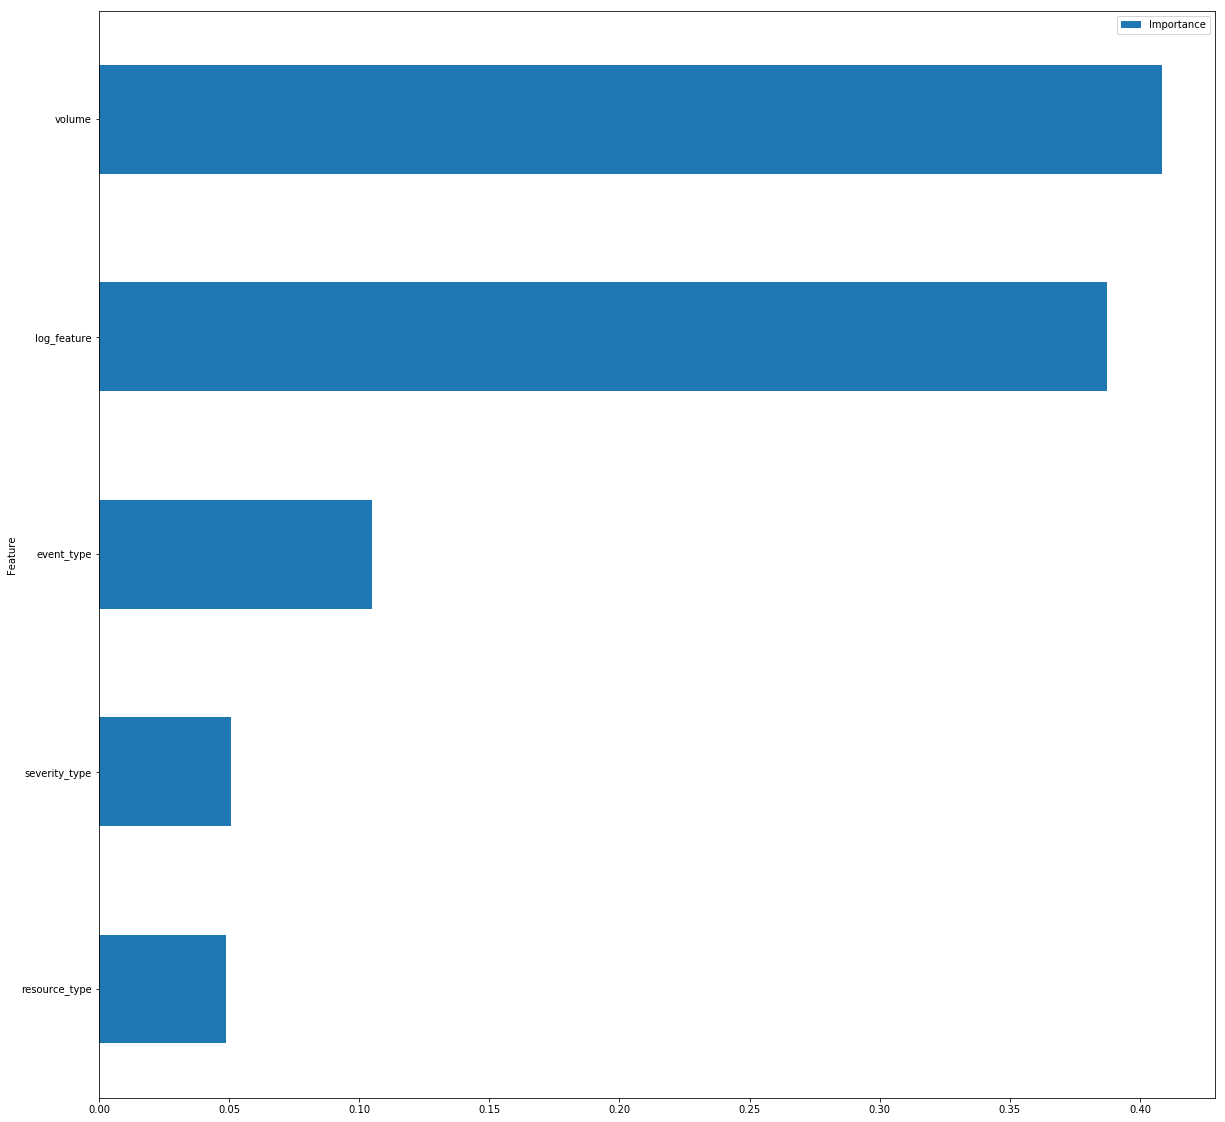

In [13]:
#Feature Importance based on Random Forest
features = pd.DataFrame()
features['Feature'] = X_train.columns
features['Importance'] = clf.feature_importances_
features.sort_values(by=['Importance'],ascending=True,inplace=True)
features.set_index('Feature',inplace=True)
features.plot(kind='barh',figsize=(20,20))

In [14]:
#Gradient Boosting classifier

clf = GradientBoostingClassifier()
clf = clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
#print(mean_squared_error(y_test, y_pred)**0.5)
#print(r2_score(y_test, y_pred))
print(accuracy_score(y_test, y_pred)) #Percent of corrent predictions

#Extreme Gradient Boosting

C:\Users\Magu\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.646952595937


In [15]:
#Precision and Recall (Confusion Matrix) based on Gradient Boosting
#One against all methodolgy since 3 target outcomes (not binary)

conf = pd.DataFrame(confusion_matrix(y_test,y_pred),columns=['No Faults','Few Faults','Many Faults'])

#Confustion Matrix Analysis by hand
    #No Faults vs others
        #Precision =  1433 / (1433 + 774) = 65%
        #Recall = 1433 / (1434 + 6) = 99%
    #Few Faults vs others - zero true positives so zero precision and recall
        #Precision = 0% 
        #Recall = 0% 
    #Many Faults vs others - zero true positives so zero precision and recall
        #Precision = 0% 
        #Recall = 0%
        
prec = precision_score(y_test,y_pred,labels=None,pos_label=1,average=None,sample_weight=None)
#[ 0.64929769,  0.        ,  0.        ]

rec = recall_score(y_test,y_pred,labels=None,pos_label=1,average=None,sample_weight=None)
#[ 0.99583044,  0.        ,  0.        ]

#Calculate Probability of classification
prob = clf.predict_proba(X_test)

conf #columns = predicted, rows = actual

,No Faults,Few Faults,Many Faults
0,1433,5,1
1,557,0,0
2,217,2,0


In [16]:
#Output csv
#CSV file with the location of the tower, followed by the classified fault_severity,
#& if possible (check the sample project), the probabilities of the different fault_severity.

sub = pd.DataFrame(OrderedDict({'location': x_test.location,'fault severity':y_pred,
    'prob of fault zero':prob[:,0],'prob of fault one':prob[:,1],'prob of fault two':prob[:,2]}))

sub.to_csv('disruption_v2.csv', index=False)
